# Pix2pix for Vein Segmentation

## 1. Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import shutil
import random
import numpy as np
import cv2

from matplotlib import pyplot as plt
from IPython import display
from pathlib import Path
from glob import glob
from scipy.io import loadmat
from IPython.display import clear_output

from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Load the dataset


In [ ]:
if os.path.exists("/content/dataset"):
  shutil.rmtree("/content/dataset")

# Download the dataset
!unzip -qn '/content/gdrive/Datasets 📊/CUBITAL/square_final_dataset512x512.zip' > /dev/null
shutil.move("/content/content/final_dataset","/content/dataset")
shutil.rmtree("/content/content")

## 3. Creating a TensorFlow Dataset

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 3
DATA_DIR = "/content/dataset"
EXPERIMENTS_PATH = "/content/gdrive/ML Experiments 🧪/deeplabv3/"

TOTAL_IMAGES = len(os.listdir(os.path.join(DATA_DIR,"images")))

print("Total images:",TOTAL_IMAGES)

NUM_TRAIN_IMAGES = int(TOTAL_IMAGES * 0.70)
NUM_VAL_IMAGES = int(TOTAL_IMAGES * 0.20)
NUM_TEST_IMAGES = int(TOTAL_IMAGES * 0.10)

print("Number of train images:",NUM_TRAIN_IMAGES," val images:",NUM_VAL_IMAGES," test images:",NUM_TEST_IMAGES)

train_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

test_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))[NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : ]
test_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))[NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : ]

def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  else:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 127.5 - 1
  return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Total images: 10000
Number of train images: 7000  val images: 2000  test images: 1000
Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None))>
Test Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None))>


Plot a sample of the input (real image) and output (mask image):  

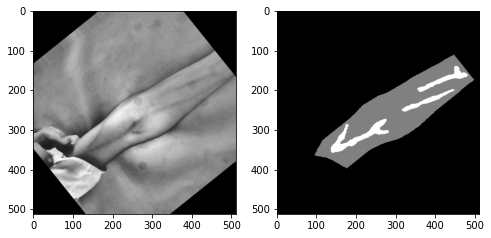

In [ ]:
def show_instance(image, mask):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image)

  # Read and decode an image file to a uint8 tensor
  mask = tf.io.read_file(mask)
  mask = tf.io.decode_jpeg(mask)

  # Convert both images to float32 tensors
  image = tf.squeeze(tf.cast(image, tf.float32))
  mask = tf.squeeze(tf.cast(mask, tf.float32))

  # Casting to int for matplotlib to display the images
  fig, axs = plt.subplots(1,2, figsize=(8, 12))
  axs[0].imshow(image, cmap="gray")
  axs[1].imshow(mask, cmap="gray")

num = random.randint(0, len(train_images))
show_instance(train_images[num], train_masks[num])

In [ ]:
def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  else:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 127.5 - 1
  return image

image = read_image(train_images[num])
image.shape

TensorShape([512, 512, 1])

## 4. Model development

## 4.1 Define

In [ ]:
# Model
from keras.layers import ReLU
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization

class Encoder(Layer):

    def __init__(self, filters, apply_norm=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.filters = filters
        self.apply_norm = apply_norm

        self.c1 = Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.act = LeakyReLU()

    def call(self, X):
        x = self.c1(X)
        if self.apply_norm :
            x = self.bn(x)
        x = self.act(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "apply_norm":self.apply_norm
        }

class Decoder(Layer):

    def __init__(self, filters, apply_dropout=False, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.filters = filters
        self.apply_dropout = apply_dropout

        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.drop = Dropout(0.5)
        self.act = ReLU()


    def call(self, X):
        x = self.cT(X)
        x = self.bn(x)
        if self.apply_dropout:
            x = self.drop(x)
        x = self.act(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "apply_dropout":self.apply_dropout
        }

# Inputs
gen_input = Input(shape=(512,512,3), name="Input")

# Encoder - Downsampling Phase
c1 = Encoder(64, apply_norm=False, name="Encoder1")(gen_input)
c2 = Encoder(128, name="Encoder2")(c1)
c3 = Encoder(256, name="Encoder3")(c2)
c4 = Encoder(512, name="Encoder4")(c3)
c5 = Encoder(512, name="Encoder5")(c4)
c6 = Encoder(512, name="Encoder6")(c5)

# Encoding - Latent Representation
e = Encoder(512, name="Encoding")(c6)

#  Attention plus decoder network.
d1 = Decoder(512,apply_dropout=True,name="Decoder1")(e)
a1 = concatenate([d1, c6])

d2 = Decoder(512,apply_dropout=True,name="Decoder2")(a1)
a2 = concatenate([d2, c5])

d3 = Decoder(512,apply_dropout=True,name="Decoder3")(a2)
a3 = concatenate([d3, c4])

d4 = Decoder(512, name="Decoder4")(a3)
a4 = concatenate([d4, c3])

d5 = Decoder(256, name="Decoder5")(a4)
a5 = concatenate([d5, c2])

d6 = Decoder(128, name="Decoder6")(a5)
a6 = concatenate([d6, c1])

d7 = Decoder(64, name="Decoder7")(a6)

init = tf.random_normal_initializer(stddev=0.02)
gen_out = Conv2D(3, kernel_size=1, strides=1, padding='same', activation='tanh', kernel_initializer=init, name="gen_out")(d7)

# Model
generator = Model(
    inputs=gen_input,
    outputs=gen_out,
    name="Generator"
)

# Compiling
generator.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

### 4.1 Define model

### 4.2 Train model

### 4. Restore the latest checkpoint and test the network

In [ ]:
!ls "$checkpoint_prefix"

checkpoint		     ckpt-23.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-23.index
ckpt-10.index		     ckpt-24.data-00000-of-00001
ckpt-11.data-00000-of-00001  ckpt-24.index
ckpt-11.index		     ckpt-25.data-00000-of-00001
ckpt-12.data-00000-of-00001  ckpt-25.index
ckpt-12.index		     ckpt-26.data-00000-of-00001
ckpt-13.data-00000-of-00001  ckpt-26.index
ckpt-13.index		     ckpt-27.data-00000-of-00001
ckpt-14.data-00000-of-00001  ckpt-27.index
ckpt-14.index		     ckpt-28.data-00000-of-00001
ckpt-15.data-00000-of-00001  ckpt-28.index
ckpt-15.index		     ckpt-2.data-00000-of-00001
ckpt-16.data-00000-of-00001  ckpt-2.index
ckpt-16.index		     ckpt-3.data-00000-of-00001
ckpt-17.data-00000-of-00001  ckpt-3.index
ckpt-17.index		     ckpt-4.data-00000-of-00001
ckpt-18.data-00000-of-00001  ckpt-4.index
ckpt-18.index		     ckpt-5.data-00000-of-00001
ckpt-19.data-00000-of-00001  ckpt-5.index
ckpt-19.index		     ckpt-6.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-6.index
ckpt-1.index

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### 4. Generate some images using the test set

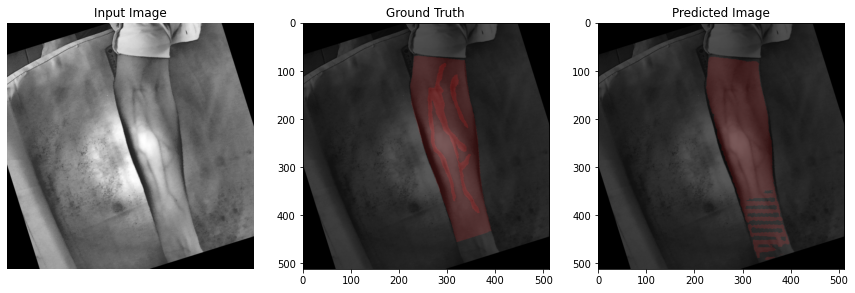

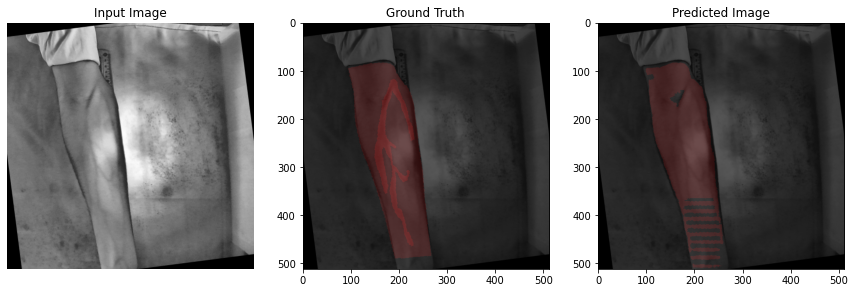

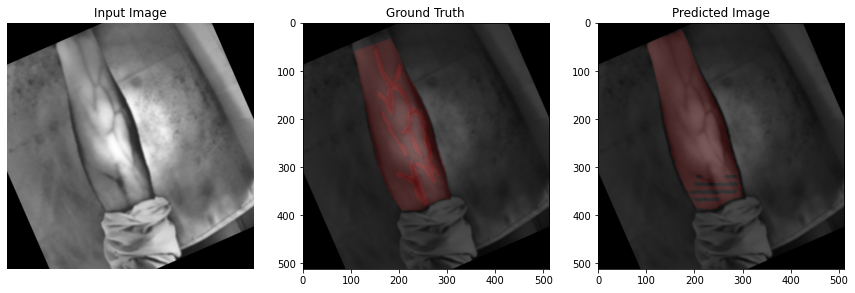

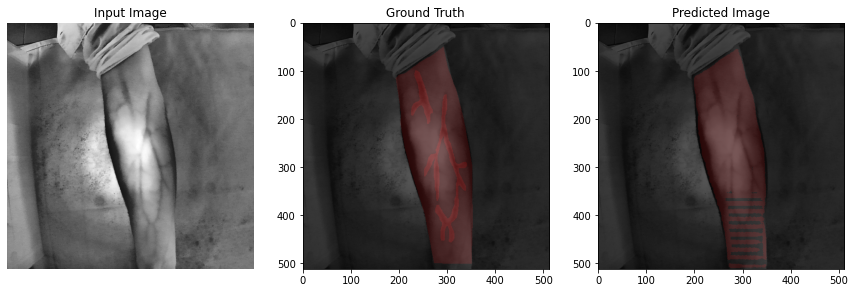

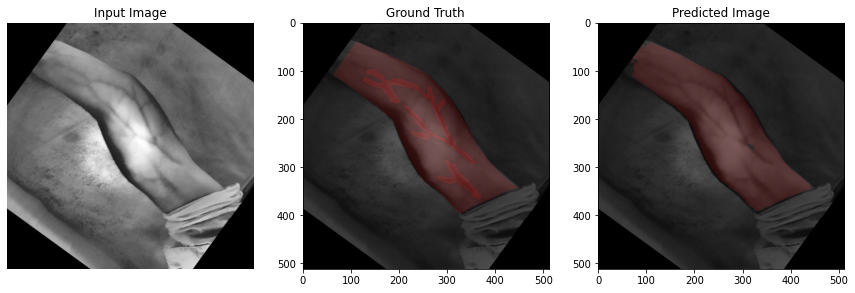

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)